In [130]:
import pandas as pd
import psycopg2
from sklearn.preprocessing import (
    MinMaxScaler,
    MaxAbsScaler,
    StandardScaler,
    RobustScaler,
)

SCHEMA = {
    "wb_hnp": [
        "hdi",
        "gni",
        "life_satis",
    ],
    "country": ["life_expectancy", "crude_birth_rate", "crude_death_rate", "name"],
    "health": [
        "domestic_health_expenditure",
        "immunization_hepb",
        "immunization_measles",
        "stillbirth_rate",
        "mort_infant",
        "mort_non_communicable_disease",
        "mort_traffic_injury"
    ],
    "qualityoflife": [
        "unemployment_rate",
        "suicide_rate",
        "sanitation_access",
        "drinking_water_access",
    ],
    "nutrition": [
        "hyperten",
        "undernour",
    ],
    "population": ["p_growth_urban", "p_growth_rural"],
    "month": ["year"]
}


In [131]:
conn = psycopg2.connect("host=wb-hnp.postgres.database.azure.com user=bigboss dbname=postgres  password=@!p2T+u:x{cB")


cursor = conn.cursor()
query = f"SELECT DISTINCT {','.join([table + '.' + attribute for table, attributes in SCHEMA.items() for attribute in attributes])} FROM {','.join([table for table in SCHEMA.keys()])} WHERE {' AND '.join([f'wb_hnp.{table}_key = {table}.{table}_key' for table in SCHEMA.keys() if table != 'wb_hnp'])} "

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(
    list(map(list, data)),
    columns=[
        attribute for _, attributes in SCHEMA.items() for attribute in attributes
    ],
)



Text(0.5, 1.0, 'Histogram of Life Satisfaction')

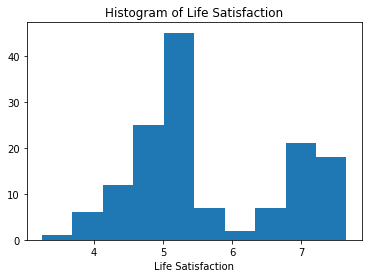

In [55]:
plt.hist(df.life_satis)
plt.xlabel("Life Satisfaction")
plt.title("Histogram of Life Satisfaction")

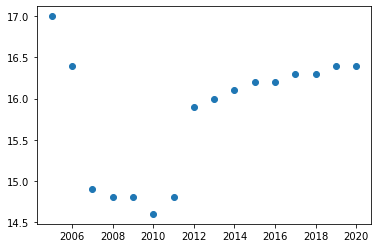

In [136]:
lebanon_sucks = df[df.name.eq("Lebanon")][["mort_traffic_injury", "year"]]
plt.scatter(lebanon_sucks.year, lebanon_sucks.mort_traffic_injury)

In [ ]:
﻿HDI Rank,Level,1990,,1991,,1992,,1993,,1994,,1995,,1996,,1997,,1998,,1999,,2000,,2001,,2002,,2003,,2004,,2005,,2006,,2007,,2008,,2009,,2010,,2011,,2012,,2013,,2014,,2015,,2016,,2017,,2018,,2019,


In [69]:
hdi_dict = {"very high":[0.779,0.782,0.78,0.79,0.795,0.799,0.804,0.804,0.813,0.818,0.823,0.827,0.832,0.837,0.841,0.846,0.851,0.855,0.86,0.861,0.866,0.871,0.874,0.878,0.882,0.886,0.888,0.89,0.892,0.898],
"high": [0.568,0.573,0.578,0.584,0.588,0.596,0.604,0.61,0.616,0.622,0.63,0.636,0.643,0.65,0.657,0.665,0.675,0.684,0.692,0.698,0.706,0.713,0.72,0.727,0.733,0.738,0.743,0.746,0.75,0.753],
"medium":[0.437,0.439,0.445,0.451,0.457,0.464,0.471,0.476,0.484,0.491,0.497,0.502,0.508,0.518,0.527,0.536,0.544,0.553,0.56,0.567,0.575,0.584,0.593,0.599,0.608,0.616,0.625,0.63,0.634,0.631],
"low": [0.352,0.353,0.355,0.356,0.356,0.361,0.368,0.373,0.379,0.384,0.386,0.393,0.402,0.417,0.426,0.435,0.444,0.452,0.461,0.469,0.473,0.479,0.484,0.49,0.496,0.499,0.501,0.505,0.507,0.513]}
hdi_dict = {key: value[15:] for key,value in hdi_dict.items()}

In [ ]:
low <= 0.435
0.435 < medium <= 0.536
0.536 < high <
0.846< very_high 

In [74]:
y_data_plus_year = df[["hdi", "year"]]

In [84]:
y = []
for  index, row in y_data_plus_year.iterrows():
    hdi = row.hdi
    year = row.year
    label = "very high"
    for name, arr in hdi_dict.items():
        if year != 2020:
            val = arr[int(year)-2005]
        else:
            val = arr[-1]
        if hdi >= val:
            label = name
            break
    y.append(label)

## Normalization

In [137]:
X_unnormalized = df.loc[:, ~df.columns.isin(["name", "year", "hdi"])]

In [138]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X_unnormalized)

In [103]:
labels_to_num = {"very high": 2,"high": 1, "medium": 0}
Y = np.asarray([labels_to_num[i] for i in y])

## Feature Selection

In [256]:
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.svm import SVC

selector = RFE(DecisionTreeClassifier(), n_features_to_select=5, step=1)
X_new = selector.fit_transform(X, Y)

In [258]:
X_unnormalized.columns[selector.support_]

Index(['gni', 'life_satis', 'suicide_rate', 'undernour', 'p_growth_urban'], dtype='object')

## Splitting Data

In [259]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X_new, np.asarray(Y), test_size=0.33, random_state=42, stratify=Y)

<BarContainer object of 3 artists>

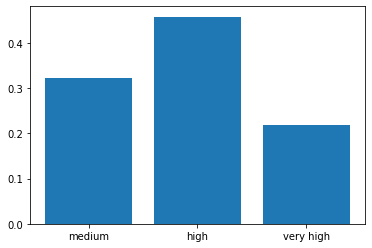

In [223]:
avgs_1 = []
avgs_2 = []
for i in range(0,3):
    avgs_1.append(y_train[y_train == i].shape[0]/y_train.shape[0])
    avgs_2.append(y_test[y_test == i].shape[0]/y_test.shape[0])

plt.bar(["medium","high","very high"], avgs_1)

<BarContainer object of 3 artists>

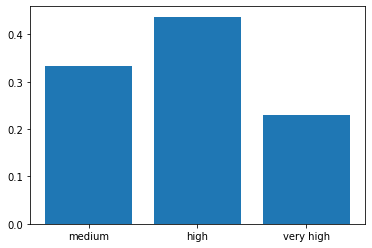

In [181]:
plt.bar(["medium","high","very high"], avgs_2)

## Classification

### Decision Tree

In [270]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.03)

In [271]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.03, random_state=0)

In [272]:
predictions = clf.predict(X_test)

In [273]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43        16
           1       0.56      0.67      0.61        21
           2       0.36      0.36      0.36        11

    accuracy                           0.50        48
   macro avg       0.47      0.47      0.47        48
weighted avg       0.50      0.50      0.49        48



In [274]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.75      0.58      0.65        31
           1       0.64      0.68      0.66        44
           2       0.44      0.52      0.48        21

    accuracy                           0.61        96
   macro avg       0.61      0.60      0.60        96
weighted avg       0.63      0.61      0.62        96



[Text(2092.5, 4756.5, 'p_growth_urban <= -0.593\ngini = 0.638\nsamples = 96\nvalue = [31, 44, 21]\nclass = high'),
 Text(1395.0, 3397.5, 'gini = 0.621\nsamples = 25\nvalue = [4, 10, 11]\nclass = very high'),
 Text(2790.0, 3397.5, 'life_satis <= -0.292\ngini = 0.606\nsamples = 71\nvalue = [27, 34, 10]\nclass = high'),
 Text(1395.0, 2038.5, 'life_satis <= -0.52\ngini = 0.637\nsamples = 37\nvalue = [17, 12, 8]\nclass = medium'),
 Text(697.5, 679.5, 'gini = 0.64\nsamples = 22\nvalue = [5, 10, 7]\nclass = high'),
 Text(2092.5, 679.5, 'gini = 0.338\nsamples = 15\nvalue = [12, 2, 1]\nclass = medium'),
 Text(4185.0, 2038.5, 'gni <= 1.494\ngini = 0.491\nsamples = 34\nvalue = [10, 22, 2]\nclass = high'),
 Text(3487.5, 679.5, 'gini = 0.333\nsamples = 25\nvalue = [4, 20, 1]\nclass = high'),
 Text(4882.5, 679.5, 'gini = 0.494\nsamples = 9\nvalue = [6, 2, 1]\nclass = medium')]

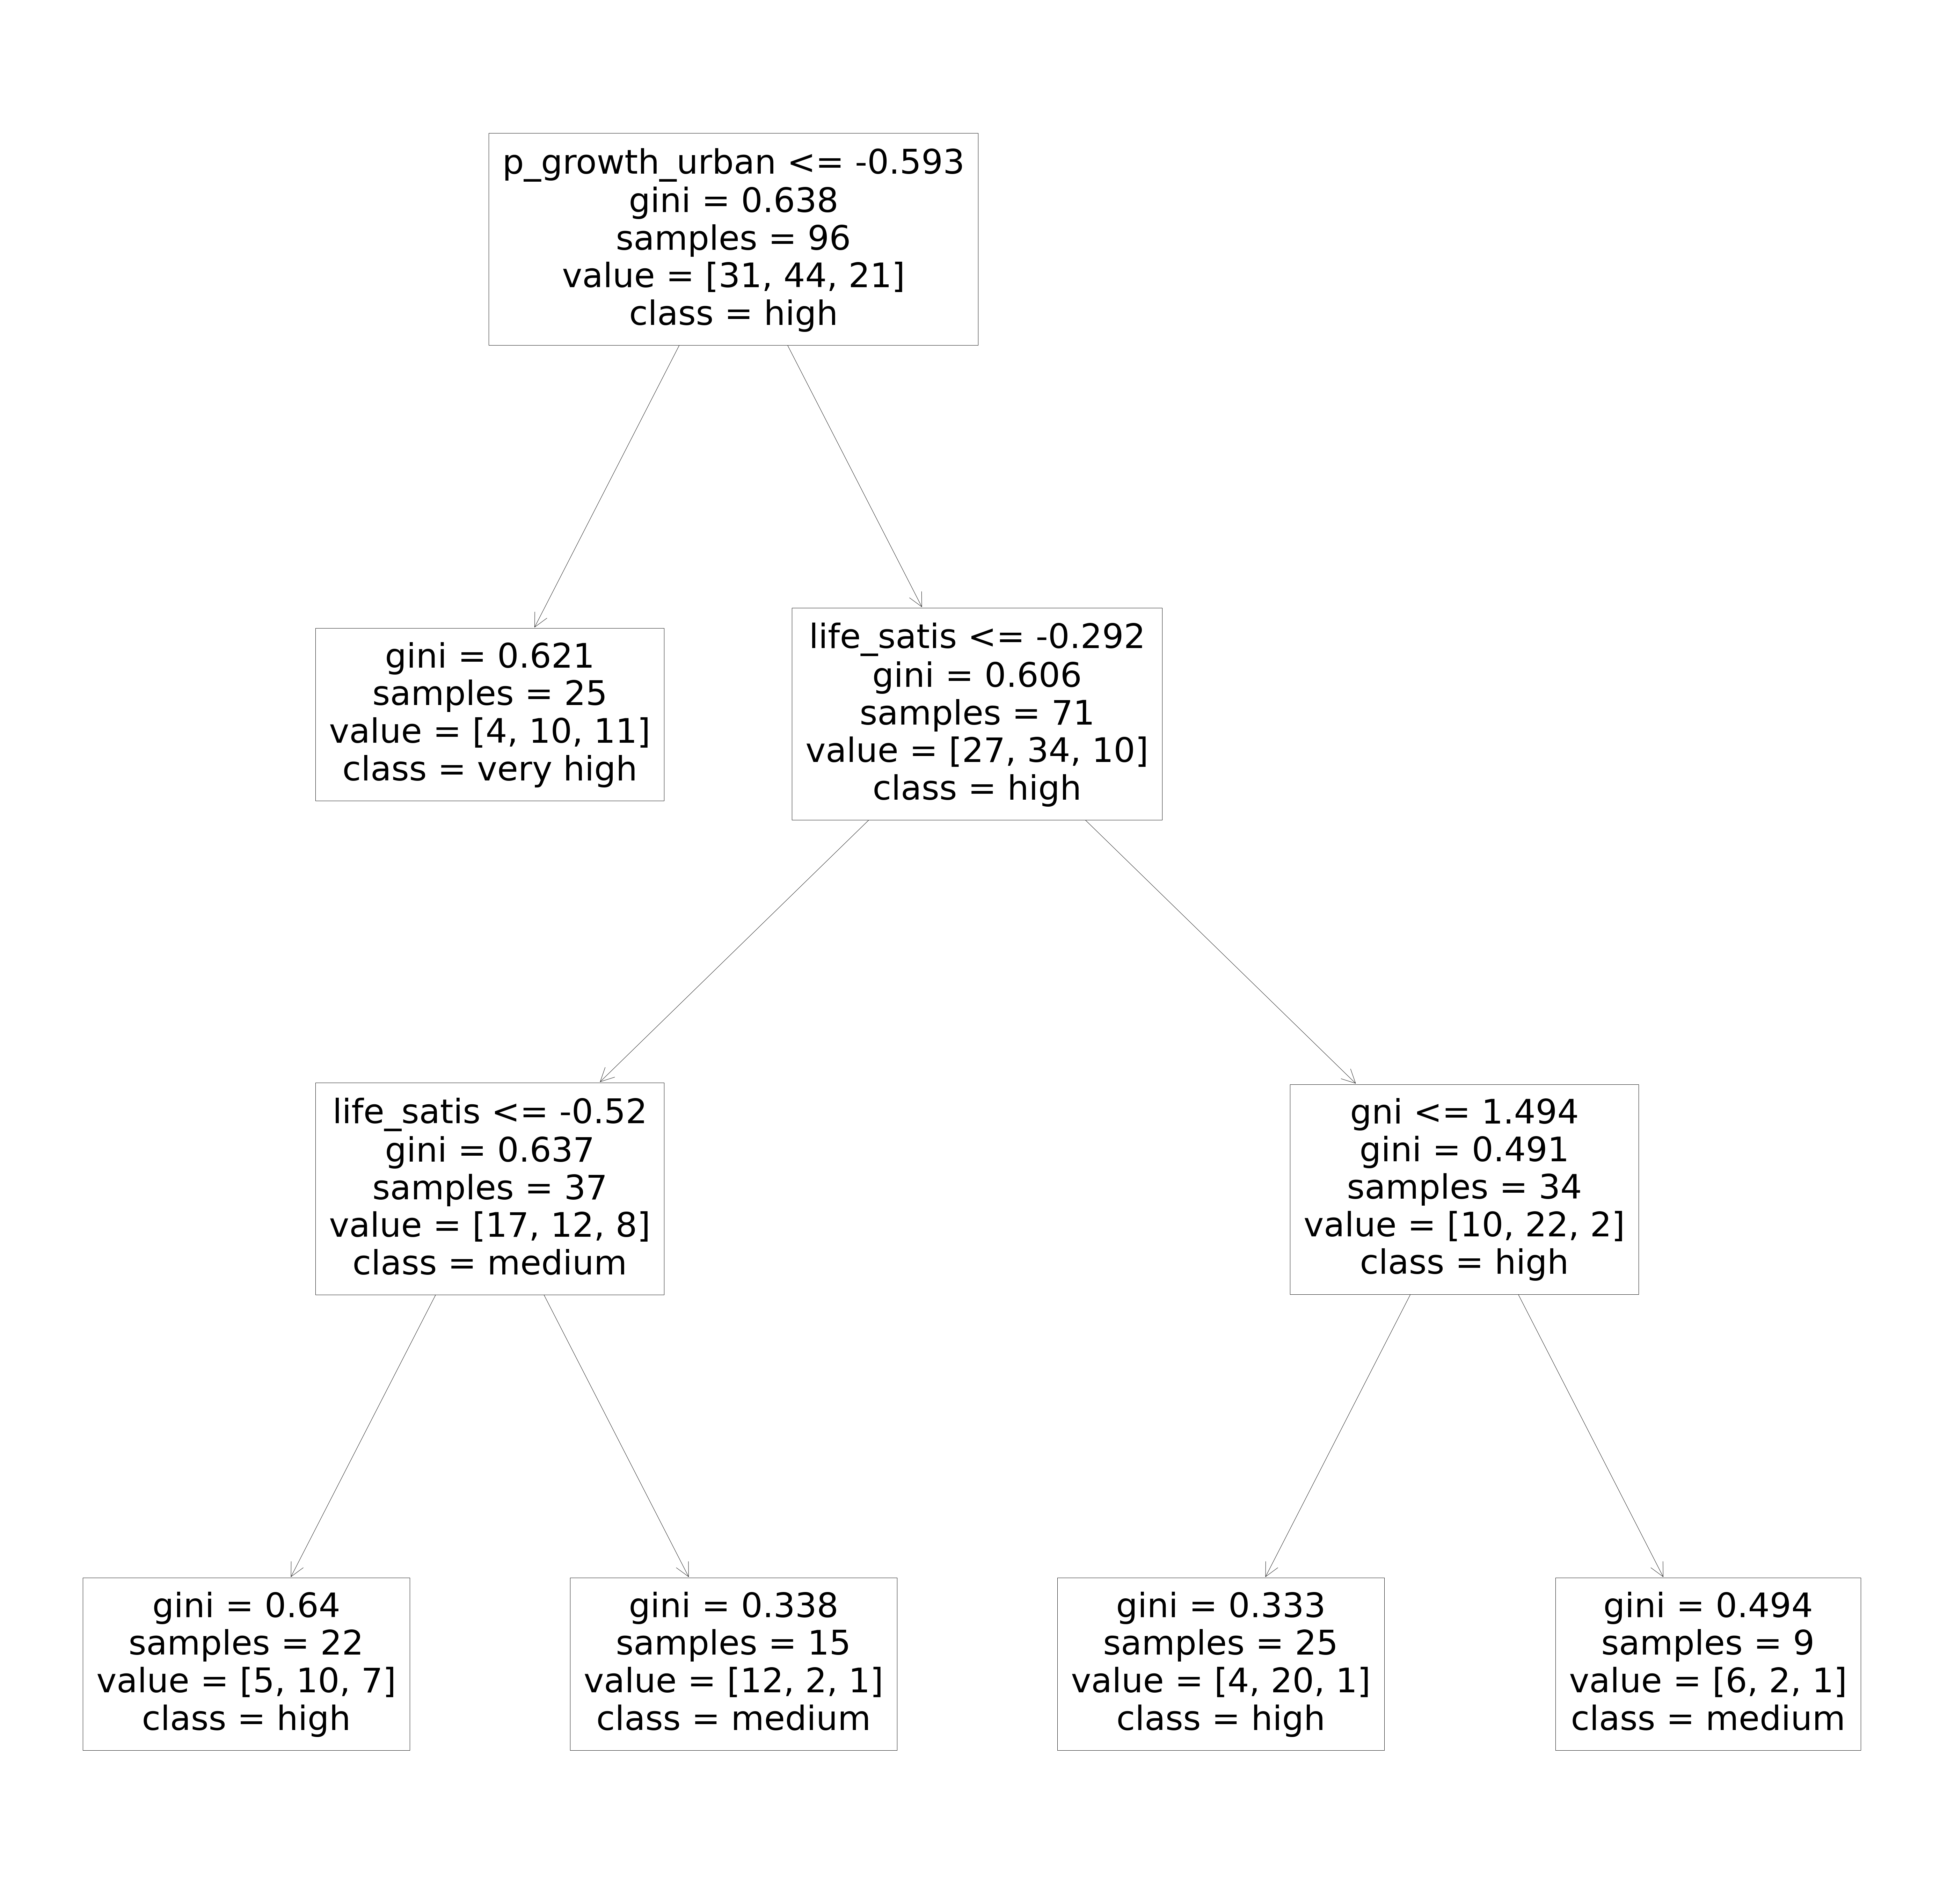

In [279]:
from sklearn import tree
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111)
tree.plot_tree(clf,ax=ax, feature_names=X_unnormalized.columns[selector.support_], class_names=["medium", "high", "very high"])

### Random Forest

In [306]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [310]:
clf_forest = RandomForestClassifier(max_depth=5)
acc_train = []
acc_test = []
for d in range(2,10):
    clf_forest = RandomForestClassifier(max_depth=d)
    clf_forest.fit(X_train, y_train)
    acc_train.append(accuracy_score(y_train, clf_forest.predict(X_train)))
    acc_test.append(accuracy_score(y_test, clf_forest.predict(X_test)))

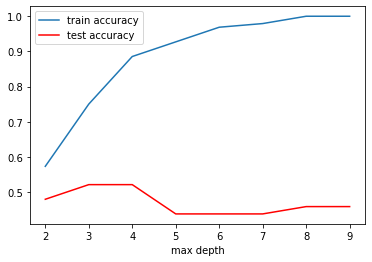

In [315]:
plt.plot(range(2,10),acc_train, label="train accuracy")
plt.plot(range(2,10), acc_test, c="red", label="test accuracy")
plt.xlabel("max depth")
plt.legend()

In [303]:
clf_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [316]:
print(classification_report(y_test, clf_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.31      0.38        16
           1       0.50      0.67      0.57        21
           2       0.30      0.27      0.29        11

    accuracy                           0.46        48
   macro avg       0.43      0.42      0.41        48
weighted avg       0.45      0.46      0.44        48



In [305]:
print(classification_report(y_train, clf_forest.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.88      0.98      0.92        44
           2       1.00      0.86      0.92        21

    accuracy                           0.92        96
   macro avg       0.94      0.90      0.92        96
weighted avg       0.92      0.92      0.92        96



### Gradient Boosting

In [355]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0, ccp_alpha=0.05)

In [356]:
clf_gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.05, learning_rate=1.0, max_depth=5,
                           random_state=0)

In [357]:
print("TEST SET: ")
print(classification_report(y_test, clf_gbc.predict(X_test)))
print("\n\n\nTRAIN SET: ")
print(classification_report(y_train, clf_gbc.predict(X_train)))

TEST SET: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.44      1.00      0.61        21
           2       0.00      0.00      0.00        11

    accuracy                           0.44        48
   macro avg       0.15      0.33      0.20        48
weighted avg       0.19      0.44      0.27        48




TRAIN SET: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.46      1.00      0.63        44
           2       0.00      0.00      0.00        21

    accuracy                           0.46        96
   macro avg       0.15      0.33      0.21        96
weighted avg       0.21      0.46      0.29        96



/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/anaconda3/lib/python3.7/site-p